# E-23 프로젝트: Movielens 영화 SBR

Movielens 1M Dataset 기반으로 Session Based Recommendation 시스템 제작.



In [66]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

## 데이터셋

In [67]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose-data/ml-1m') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


- 여기서 이전 실습내역과 가장 크게 다른 부분은 바로 SessionID 대신 UserID 항목이 들어갔다는 점입니다. 이 데이터셋은 명확한 1회 세션의 SessionID를 포함하지 않고 있습니다. 그래서 이번에는 UserID가 SessionID 역할을 해야 합니다.

- Rating 정보가 포함되어 있습니다. 이전 실습내역에서는 이런 항목이 포함되어 있지 않았으므로, 무시하고 제외할 수 있습니다. 하지만, 직전에 봤던 영화가 맘에 들었는지 여부가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있습니다. 아울러, Rating이 낮은 데이터를 어떻게 처리할지도 고민해야 합니다.

- Time 항목에는 UTC time 가 포함되어, 1970년 1월 1일부터 경과된 초단위 시간이 기재되어 있습니다.

## 데이터 전처리
- 항목별 기본분석
- session length
- session time
- cleaning

Session 이 아닌 UserID 단위로 데이터가 생성되어 있으므로, Session 단위로 어떻게 해석할 것인지?  
Time column 이 UTC time 으로 되어있기 때문에, datetime 형태로 바꿔주자.

In [78]:
cp_data = data.copy()

cp_data['Time'] = pd.to_datetime(data['Time']*1e9)

In [79]:
cp_data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


In [80]:
data['Time'] = cp_data['Time']

### 유저 수와 아이템 수 확인

In [6]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

Item Length

In [34]:
item_length = data.groupby('ItemId').size()
item_length

ItemId
1       2077
2        701
3        478
4        170
5        296
        ... 
3948     862
3949     304
3950      54
3951      40
3952     388
Length: 3706, dtype: int64

In [35]:
  item_length.median(), item_length.mean()

(123.5, 269.88909875876953)

In [36]:
item_length.min(), item_length.max()

(1, 3428)

### Session Length 확인

In [7]:
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [8]:
  session_length.median(), session_length.mean()

(96.0, 165.5975165562914)

In [9]:
session_length.min(), session_length.max()

(20, 2314)

In [10]:
session_length.quantile(0.999)

1343.181000000005

99,9% 의 세션(유저)은 길이가 약 1343 이하.   
길이가 가장 긴 세션(유저)을 살펴보자

In [17]:
long_session = session_length[session_length==2314].index[0]
data[data['UserId']==long_session]

,UserId,ItemId,Rating,Time
696969,4169,1268,5,965333392
697168,4169,2617,4,965333392
697185,4169,2628,4,965333392
697219,4169,2653,4,965333392
697275,4169,423,3,965333392
...,...,...,...,...
697882,4169,3754,2,1024174347
695702,4169,1413,3,1024175031
697358,4169,494,4,1024175760
695945,4169,1804,2,1024175783


짧은 시간에 엄청 많은 평점을 남긴 것으로 보인다!   
시각화 해서 파악

In [19]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

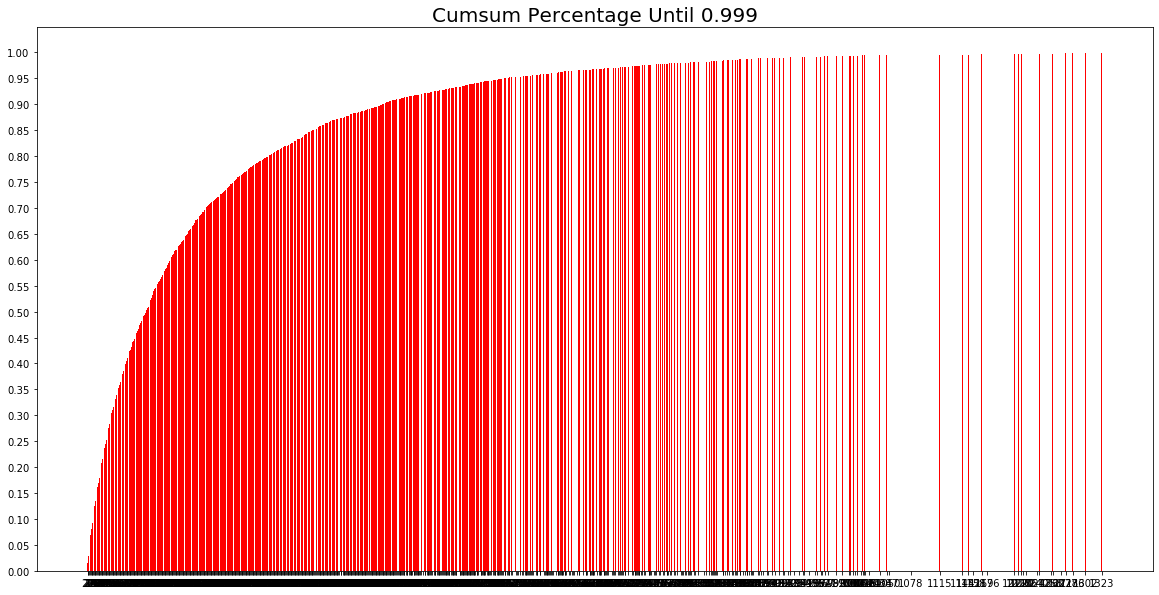

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

### Session Time

In [87]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)
print(latest-oldest)

2000-04-25 23:05:32
2003-02-28 17:49:50
1038 days 18:44:18


### 모든 데이터 사용? 1년치만 사용?
대략 3년치 데이터임. (1039일치 데이터)

1. 우선, 모든 데이터를 사용
2. 1년치 데이터도 만들어놓고, 모든 데이터를 사용한 경우의 결과가 좋지 않으면 사용해본다.

데이터가 총 100만건밖에 되지 않는데 그걸 또 최근 1년치로 자르는 것이 오히려 역효과가 나타날 수도 있겠다는 생각! 그리고 영화같은 경우 선호도가 그렇게 급격하게 변하지 않는다고 생각하기 때문에. 

### Data Cleansing
- 너무 적게 추천받은 항목을 제거한다

In [82]:
def cleanse_recursive(data: pd.DataFrame,least_rating) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_unpopular_item(data, least_rating)
        after_len = len(data)
        if before_len == after_len:
            break
    return data

def cleanse_unpopular_item(data: pd.DataFrame, least_rating):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_rating].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [83]:
data = cleanse_recursive(data, least_rating=7)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


최소 추천 받은 수 기준을 7 로 잡으면,    
1000209 => 999254, 약 1000 개의 데이터 삭제

In [84]:
data = cleanse_recursive(data, least_rating=10)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


최소 추천 받은 수 기준을 10으로 잡으면,    
1000209 => 998539, 약 1700 개의 데이터 삭제

In [85]:
data = cleanse_recursive(data, least_rating=20)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


최소 추천 받은 수 기준을 20으로 잡으면,    
1000209 => 995492, 약 5000 개의 데이터 삭제

In [86]:
data = cleanse_recursive(data, least_rating=40)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


최소 추천 받은 수 기준을 40으로 잡으면,    
1000209 => 984878, 약 15000 개의 데이터 삭제.(약 1.5%)   
40기준을 40으로 잡고 진행.

### Train,Valid, Test Split

데이터가 1039일치 데이터이기 때문에, training 831일, valid 104일, test 104일 나누자

In [159]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    # session_last_time = data.groupby('UserId')['Time'].max()

    # print(final_time,session_last_time)    
    # print(final_time,final_time - dt.timedelta(n_days))
# 끝 날짜에서 n_days일 뺀거 이전 데이터를 train으로 그리고 n_days일만큼을 test 로 나누고
# 다시 n_days일 뺀거 이전 데이터에서 1일 뺀 데이터를 train으로 그리고 n_days일만큼을 val 로 나누는 코드 
    # print(dt.datetime(2002,11,17) < (final_time - dt.timedelta(n_days)) )
    # print(data['Time'] < (final_time - dt.timedelta(n_days)))
    # print(data[data['Time'] < final_time - dt.timedelta(n_days)])
    # session_in_train = data[data['Time'] < final_time - dt.timedelta(n_days)].index
    session_in_train = data[data['Time'] < final_time - dt.timedelta(n_days)]
    # print(session_in_train)
    # session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index
    # session_in_test = data[data['Time'] >= final_time - dt.timedelta(n_days)].index
    session_in_test = data[data['Time'] >= final_time - dt.timedelta(n_days)]
    # print(session_in_test)

    # before_date = data[data['Time'].isin(session_in_train)]
    before_date = session_in_train
    # after_date = data[data['Time'].isin(session_in_test)]
    after_date = session_in_test
    # after_date = after_date[after_date['UserId'].isin(before_date['UserId'])]
    return before_date, after_date

In [160]:
tr, test = split_by_date(data, n_days=104)
tr, val = split_by_date(tr, n_days=104)

In [161]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Users: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [162]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 974351
	 Users: 6039
	 Items: 2673
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-08-04 14:38:10

* valid Set Stats Info
	 Events: 5283
	 Users: 240
	 Items: 1850
	 First Time : 2002-08-04 18:10:16
	 Last Time : 2002-11-16 17:45:42

* test Set Stats Info
	 Events: 5244
	 Users: 256
	 Items: 1803
	 First Time : 2002-11-16 17:50:29
	 Last Time : 2003-02-28 17:49:50



In [163]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [164]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

## 미니 배치의 구성

데이터셋과 미니 매치 구성. Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화 될 수 있도록!
단, 위의 데이터 전처리 부분에서 Session 단위 정의에 따라 Session-Parallel Mini-Batch가 굳이 필요하지 않을 수도 있음!

### SessionDataset

In [167]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.rating_offsets = self.get_rating_offsets()
        self.user_idx = np.arange(self.df['UserId'].nunique())  # indexing to UserId

    def get_rating_offsets(self):
        """
        Return the indexes of the first rating of each user IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [168]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [169]:
tr_dataset.rating_offsets

array([     0,     53,    182, ..., 973895, 974018, 974351], dtype=int32)

In [171]:
tr_dataset.user_idx

array([   0,    1,    2, ..., 6036, 6037, 6038])

### SessionDataLoader

SessionDataset 객체를 받아서 Session-Parallel mini-batch를 만드는 클래스를 만든다.

`__iter__` 메소드는 모델 인풋, 라벨, 세션이 끝나는 곳의 위치를 yield

mask는 후에 RNN Cell State 초기화에 사용.

In [176]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""
		
		# SessionDataset Class에 속하는 dataset 객체를 받겠다. 
    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_user, finished = self.initialize()
				# initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_user, finished = self.update_status(start, end, min_len, last_user, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_user = self.batch_size - 1    # 마지막으로 다루고 있는 user Index를 저장해둡니다.
        start = self.dataset.rating_offsets[self.dataset.user_idx[first_iters]]       # data 상에서 user가 시작된 위치를 가져옵니다.
        end = self.dataset.rating_offsets[self.dataset.user_idx[first_iters] + 1]  # user가 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_user, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_user: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_user = last_user + i  
            if new_user > self.dataset.user_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.rating_offsets[self.dataset.user_idx[new_user]]     # 종료된 유저 지점 대신 새로운 유저 지점의 시작점을 기록합니다.
            end[idx] = self.dataset.rating_offsets[self.dataset.user_idx[new_user] + 1]

        last_user += len(mask)  # 마지막 유저 지점의 위치를 기록해둡니다.
        return start, end, mask, last_user, finished

In [177]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


iterator 선언

In [178]:
iter_ex = iter(tr_data_loader)

iterator에서 next로 뽑아내서 다음 데이터 만들면 어떻게 되는지 살펴보기

In [179]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 53 65 54]
Label Item Idx are :       [ 1 54 62 24]
Previous Masked Input Idx are []


## 모델 구성

### Evaluation Metric

In [180]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [182]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [183]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [192]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_users = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [193]:
model = create_model(args)

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(128, 1, 2673)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    408750    
_________________________________________________________________
dropout_2 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_2 (Dense)              (128, 2673)               136323    
Total params: 545,073
Trainable params: 545,073
Non-trainable params: 0
_________________________________________________________________


## 모델 학습

다양한 하이퍼파라미터를 변경해보며 검증.

In [194]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [195]:
train_model(model, args)

Train:   0%|          | 0/7564 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.66]	 - Recall@20 epoch 1: 0.072917
	 - MRR@20    epoch 1: 0.011612

Train:   0%|          | 0/7564 [00:00<?, ?it/s, accuracy=0.0391, train_loss=5.33]	 - Recall@20 epoch 2: 0.069010
	 - MRR@20    epoch 2: 0.019262

Evaluation:  15%|█▌        | 6/39 [00:02<00:12,  2.61it/s]	 - Recall@20 epoch 3: 0.091146
	 - MRR@20    epoch 3: 0.024022




In [196]:
args_2 = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.01, epochs=20, k=20)
model_2 = create_model(args)

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(128, 1, 2673)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    408750    
_________________________________________________________________
dropout_3 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_3 (Dense)              (128, 2673)               136323    
Total params: 545,073
Trainable params: 545,073
Non-trainable params: 0
_________________________________________________________________


In [ ]:
train_model(model_2, args_2)

## 모델 테스트

테스트셋을 바탕으로 Recall, MRR 확인

In [ ]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model_2, args_2, test)

# 결과 보고서